In [1]:
import splat
import wisps
import wisps.simulations as wispsim
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import numpy as np
import astropy.units as u
import emcee
import splat.simulate as spsim
%matplotlib inline

In [2]:
direcs=wispsim.OBSERVED_POINTINGS

In [4]:
dlimits, spgrid, vols, vcs=wispsim.compute_effective_volumes()
dsamplers=wispsim.compute_effective_distances()

In [31]:
def flatchain(x):
    def remove_infinite(sampler):
        ##remove distances with infinite probablity
        return [~np.isinf(np.concatenate(sampler.lnprobability))]
    return [(i.flatchain[:,0])[remove_infinite(i)] for i in x]

In [32]:
distances= np.array(np.apply_along_axis(flatchain,1, dsamplers))

In [33]:
coord=SkyCoord(direcs)


In [34]:
high_idx=np.argmax(abs(coord.galactic.b)) 
low_idx=np.argmin(abs(coord.galactic.b)) 
low_idx_2nd=np.argmin((coord.galactic.b)) 


In [35]:
high_b=coord[high_idx]
low_b=coord[low_idx ]
low_b_2nd=coord[ low_idx_2nd]

In [17]:
import seaborn as sns

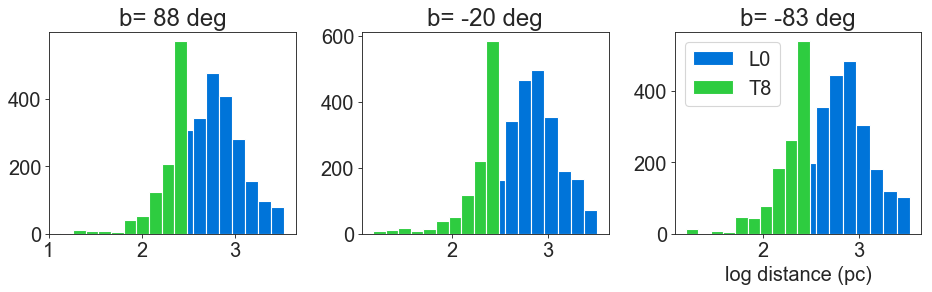

In [63]:

fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

ax[0].hist(np.log10(distances[0][high_idx]*1000),color="#0074D9", label='L0')
ax[0].hist(np.log10(distances[-1][high_idx]*1000),color="#2ECC40", label='T8')
ax[0].set_title("b= {} deg".format(round(high_b.galactic.b.value)))

ax[1].hist(np.log10(distances[0][low_idx ]*1000),color="#0074D9", label='L0')
ax[1].hist(np.log10(distances[-1][low_idx ]*1000),color="#2ECC40", label='T8')
ax[1].set_title("b= {} deg".format(round(low_b.galactic.b.value)))

ax[2].hist(np.log10(distances[0][low_idx_2nd]*1000),color="#0074D9", label='L0')
ax[2].hist(np.log10(distances[-1][low_idx_2nd]*1000),color="#2ECC40", label='T8')
ax[2].set_title("b= {} deg".format(round(low_b_2nd.galactic.b.value)))


plt.xlabel('log distance (pc)')
plt.legend()

plt.tight_layout()

In [37]:
#masses ages and such
masses, ages, teffs, spts, norm=wispsim.simulate_spts()
#drop nans in spts
ignore_spt_index=np.isnan(spts)
masses=masses[~ignore_spt_index]
ages=ages[~ignore_spt_index]
teffs=teffs[~ignore_spt_index]
spts=spts[~ignore_spt_index]

In [38]:
#relations
rels=wispsim.POLYNOMIAL_RELATIONS
f140s= rels['sp_F140W'](spts)

In [39]:
import random

In [40]:
app140s1=np.array(list(map(lambda x:x+5*np.log10(random.choice(distances[0][high_idx]*1000.0)/10), f140s)))
app140s2=np.array(list(map(lambda x: x+5*np.log10(random.choice(distances[0][low_idx ]*1000.0)/10), f140s)))
app140s3=np.array(list(map(lambda x: x+5*np.log10(random.choice(distances[0][low_idx_2nd]*1000.0)/10), f140s)))

In [41]:
snrs1=10**np.array(rels['snr_F140W'](app140s1))
snrs2=10**np.array(rels['snr_F140W'](app140s2))
snrs3=10**np.array(rels['snr_F140W'](app140s3))

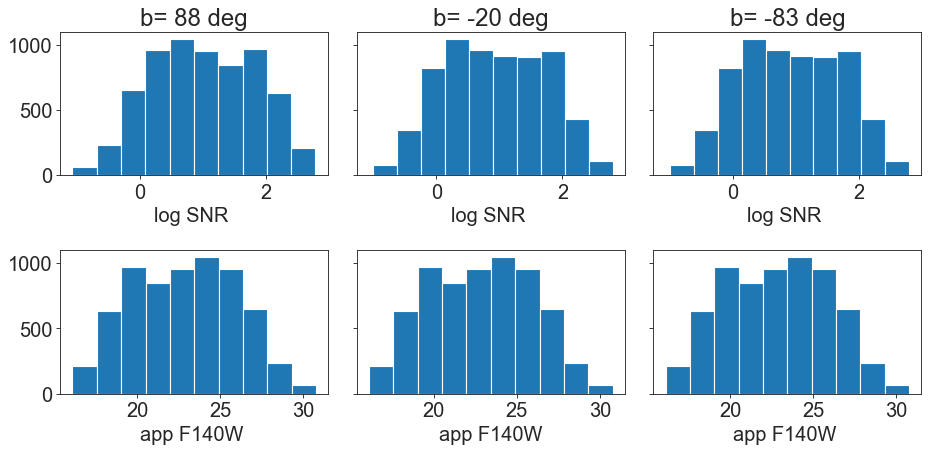

In [42]:
fig, ax=plt.subplots(ncols=3, nrows=2, sharex='row', sharey='row', figsize=(12, 6))
ax[0][0].hist(np.log10(snrs1))
#sns.distplot(np.concatenate(snrs1), ax=ax[0])
ax[0][0].set_title("b= {} deg".format(round(high_b.galactic.b.value)))

#sns.distplot(np.concatenate(snrs2), ax=ax[1])
ax[0][1].hist(np.log10(snrs2))
ax[0][1].set_title("b= {} deg".format(round(low_b.galactic.b.value)))

ax[0][2].hist(np.log10(snrs2))
ax[0][2].set_title("b= {} deg".format(round(low_b_2nd.galactic.b.value)))

ax[0][0].set_xlabel('log SNR ')
ax[0][1].set_xlabel('log SNR ')
ax[0][2].set_xlabel('log SNR ')


ax[1][0].hist(app140s1)
ax[1][1].hist(app140s1)
ax[1][2].hist(app140s1)

ax[1][0].set_xlabel('app F140W ')
ax[1][1].set_xlabel('app F140W')
ax[1][2].set_xlabel('app F140W ')

plt.tight_layout()

In [43]:
import pandas as pd
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl')

In [44]:
comb1=np.array([spts, snrs1]).T
sl1=np.array(list(map(lambda x: sf.probability_of_selection(x[0], x[1]), comb1)))
comb2=np.array([spts, snrs2]).T
sl2=np.array(list(map(lambda x: sf.probability_of_selection(x[0], x[1]), comb2)))
comb3=np.array([spts, snrs3]).T
sl3=np.array(list(map(lambda x: sf.probability_of_selection(x[0], x[1]), comb3)))

In [45]:
def get_distance(absmag, appmag):
    return 10**(-(absmag-appmag)/5.+1.0)

In [48]:
distances1=get_distance(f140s, app140s1)
distances2=get_distance(f140s, app140s2)
distances3=get_distance(f140s, app140s3)

In [52]:
len(distances1), len(spts)

(6564, 6564)

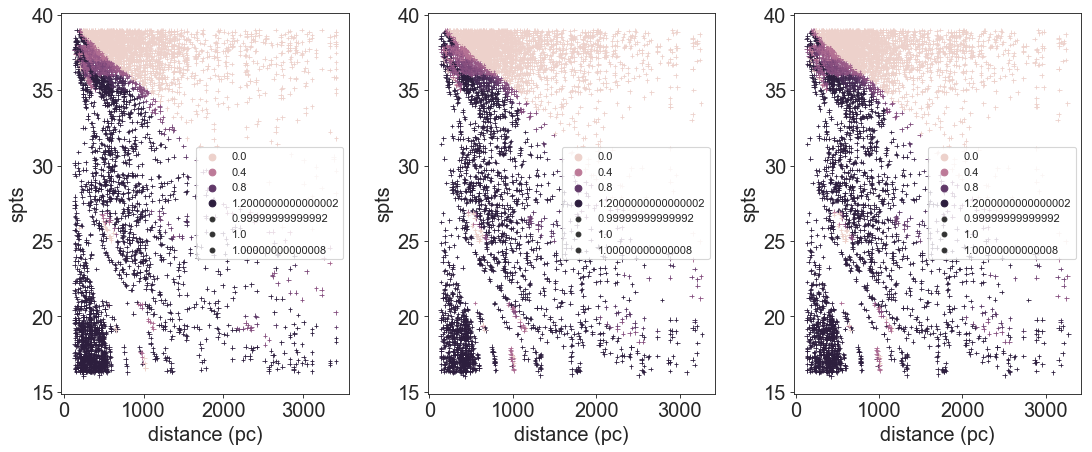

In [53]:
fig, ax=plt.subplots(ncols=3, figsize=(14, 6))
sns.scatterplot(distances1, spts, ax=ax[0], hue=sl1, cmap='viridis', 
                marker='+', size=1.0)

sns.scatterplot(distances2, spts, ax=ax[1], hue=sl2, cmap='viridis', 
                marker='+', size=1.0)

sns.scatterplot(distances2, spts, ax=ax[2], hue=sl2, cmap='viridis', 
                marker='+', size=1.0)

for a in ax:
    a.legend(loc=0, prop={'size': 10})
    a.set_xlabel('distance (pc)')
    a.set_ylabel('spts' )
    
plt.tight_layout()

Text(0, 0.5, 'spts')

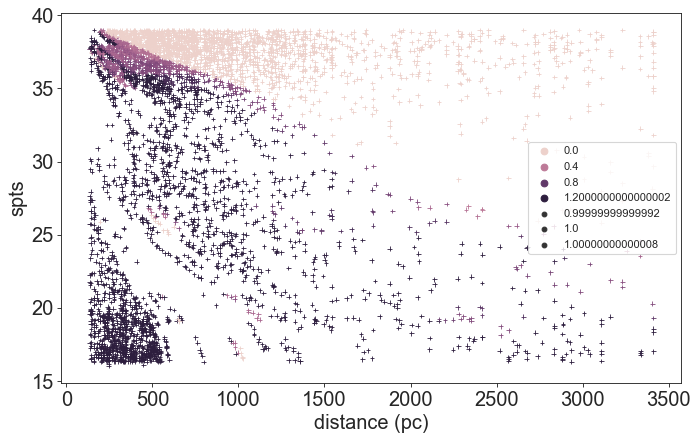

In [55]:
fig, ax=plt.subplots(figsize=(10, 6))
sns.scatterplot(distances1, spts, ax=ax, hue=sl1, cmap='viridis', 
                marker='+', size=1.0)
ax.legend(loc=0, prop={'size': 10})
ax.set_xlabel('distance (pc)')
ax.set_ylabel('spts' )